In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
from gradient_descent import gradient_descent, minibatch_class
import utils
from utils import Poisson_reg, sample_PLN

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from timeit import default_timer as timer
from tqdm import tqdm 
import time 
import sys 
import matplotlib as mpl
from cycler import cycler
plt.style.use('ggplot')

import psutil
import multiprocessing
import concurrent.futures
import threading

import numpy as np
import seaborn as sns 
import torch
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
torch.set_default_dtype(torch.float64)

In [4]:
 if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
print('device : ', device)

device :  cpu


In [5]:
class PLN_full():
    def __init__(self, C_init, beta_init, M_init, S_init, class_optimizer = torch.optim.Rprop, requires_tridiag = True): 
        '''
            Initialization : 
            'Y' : the data, size (n,p). n is the number of samples we have and p the number of species. 
                  the entries should be int but dtype = float. 
            'O': offset : additional offset. (not very important for comprehension). size (n,p)
            'covariates' : covariates, size (n,d)
            'C_init' : initialization for C. I plan to do a more advanced initialization. 
            'beta_init ' : Initialization for beta. I plan to do a more advanced initialization. 
            'M_init' : initialization for the variational parameter M
            'S_init ': initialization for the variational parameter S
            'requires_tridiag' : bool. If True, the parameters C wil be a vector 
                                of size (n(n+1)/2). It will form a lower tridiagonal matrix after,
                                but we encode it as a vector for pytorch. Advantages : we get about half less 
                                parameter if True. 
                                If False, C will be a Matrix of size (n,n). It won't be a lower tridiagonal Matrix
                                after some gradient steps. 
        '''
        # model parameters
        # we start with the initialization of C, that is the most subtle. If you want tridiagonals matrices 
        # at every iteration then the parameters C of the optimizer will be a vector ( we will change this vector 
        # into a matrix at each iteration to compute the loss. It is more convenient this way. 
        #Else, it will be a matrix

        
        if requires_tridiag : 
            self.C = torch.clone(mat2vec_lower_tridiag(C_init)).to(device)
            self.requires_tridiag = True 
        else : 
            self.C = torch.clone(C_init).to(device) 
            self.requires_tridiag = False 
            
        self.C.requires_grad_(True)
        self.Sigma = torch.clone(torch.mm(C_init,C_init.T)).to(device)
        self.Sigma.requires_grad_(False) # we don't need to have a gradient for Sigma since we will 
                                         # always update it with a closed form (since we have constraints
                                         # of positivity and symmetry)
        #note that C and sigma have a similr role here. We will use either C or Sigma 
        #depending on the loss we choose. 
        
        self.beta = torch.clone(beta_init).to(device)
        self.beta.requires_grad_(True)
        
        #variational parameters
        self.M = torch.clone(M_init).to(device)
        self.M.requires_grad_(True)
        self.S = torch.clone(S_init) .to(device)
        self.S.requires_grad_(True)
        
        
        self.params = {'S' : self.S,'M' : self.M,'C' : self.C, 'beta' : self.beta, 'Sigma' : self.Sigma}
        
        self.old_loss = 1
        
        self.class_optimizer = class_optimizer
        
        # some lists to store some stats
        self.t0 = time.time()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.ELBO_list = list()
        self.running_times = list()

        
    def extract_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. 
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0].to(device);self.O = data[1].to(device);self.covariates = data[2].to(device)
        self.n, self.p = self.Y.shape
        
        
        
    ###################### parametrisation centered in X@\beta, variance CC.T ##############
    
    
    
    def compute_ELBO(self): 
        '''
        compute the ELBO with the parameter of the model we have extract. 
        This ELBO uses the parametrization for Z ~ N(XB,Sigma)
        '''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_tridiag(self): 
        '''
        same function as above, but the parameter C is a vector here. 
        it does the same but changes C from a vector to a lower tridiagonal Matrix. 
        '''
        return ELBO_tridiag(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_Sigma(self): 
        '''
        Computes the ELBO when Sigma is the parameter, (in opposition to C)
        '''
        return ELBO_Sigma(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    
    
    
    ####################### parametrisation centered in 0, variance Sigma  ################
    
    
    
    
    
    def compute_first_ELBO(self):
        '''
        compute the ELBO of the first notebook, i.e. another parametrisation 
        '''
        return first_ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    def compute_profile_ELBO(self): 
        '''
        compute the ELBO from the profiled formula. 
        '''
        self.Sigma = first_closed_Sigma(self.M,self.S) # we update Sigma 
        gain = profile_ELBO(self.Y,self.O,self.covariates,self.M,self.S, self.Sigma,self.beta)
        return gain
    
    
    ##################### parametrisation centered in 0 and unit variance ##################
    
    
    
    
    def compute_ELBO_PCA(self): 
        '''
        compute the ELBO from the PCA parametrization.
        '''
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_PCA_tridiag(self): 
        '''
        compute the ELBO when C is a vector that encodes a tridiagonal Matrix from the PCA parametrisation
        '''
        matC = vec2mat_lower_tridiag(self.C)
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,matC ,self.beta)
    
    

    
    
    # gradient ascent function, core function of the class. 
    def torch_gradient_ascent(self, optimizer, compute_gain,params, tolerance , N_epoch ,  requires_closed_Sigma, verbose): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 

        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 

                'compute_gain' : function. It should call the parameters by itself. i.e. we wil 
                                all compute_gain() without any parameter in argument. 

                       
                'tolerance': float. the threshold we set to stop the algorithm. It will 
                              stop  if we are not improving the loss more than tolerance. 
                              
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                
                'requires_closed_Sigma' : bool. tells if we are using Sigma (True) or C(False). 
                                          Here just to keep track of the error.
                                          between self.Sigma and true_Sigma

                'Verbose' : bool. if True, will print some messages useful to 
                            interpret the gradient ascent. If False, nothing will be printed. 
 
        returns : None 
        '''
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5,patience = 3)
        # we set the gradient to zero just to make sure the gradients are properly calculated
        optimizer.zero_grad()

        stop_condition = False 
        i = 0

        while i < N_epoch and stop_condition == False: 
            optimizer.zero_grad()
            loss = -compute_gain()
            loss.backward()
            #print('sanity check : ', torch.norm(params['beta'].grad+grad_beta(data[0], data[1],data[2] ,params['M'] ,params['S'] ,params['C'] ,params['beta']) ))
            if torch.isnan(loss).item() == True : 
                #print('NAN')
                pass
            optimizer.step()
            
            delta = self.old_loss - loss.item() 
            '''
            if delta < 0 : 
                print('We regressed of ', delta )
            else : 
                print('We gain ', delta )
            '''
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            
            self.old_loss = loss.item()
            
            # keep track of the error with Sigma. 
            if requires_closed_Sigma : # if we use Sigma as parameter 
                self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            else : #if we use C 
                if len(params['C'].shape) > 1 : # C is a matrix ( requires_tridiag = False)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(self.C,self.C.T)-true_Sigma)**2).item())
                else : # C is a vector (requires_tridiag = true)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(vec2mat_lower_tridiag(self.C),
                                                           vec2mat_lower_tridiag(self.C).T)-true_Sigma)**2).item())

            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.ELBO_list.append(-loss.item())
            # print some stats if we want to
            if i%200 == 0 and verbose : 
                print('iteration number: ', i)
                print('-------UPDATE-------')
                print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
                print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
                print('ELBO : ', np.round(-loss.item(),5))
                print('Delta : ', delta)
                if i % 500 == 21 : 
                    sns.heatmap(self.Sigma)
                    plt.show()
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)

        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch, 'last delta = ', delta)
 
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
        
    
    ### we will build all the algorithms based on the previous function. The function will 
    ### basically be the same, we will change the gain considered (depends on the parametrisation we take 
    ### mainly). We will also update the parameters if we have closed form. 
    
    
    
    
    ####### parametrisation centered in 0 and unit variance #########
    
    
    
    def full_grad_ascent_PCA(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta) with the loss from the PCA
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C, self.beta], lr = lr)
        
        # we extract the data
        self.extract_data(data)
        
        #we choose the right loss. Note that both loss uses C and not Sigma. 
        #if we have chosen a tridiagonal matrix : 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_PCA_tridiag
        else : # if we have not chosen a tridiagonal matrix,
            gain = self.compute_ELBO_PCA
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, gain,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= False,verbose = verbose)
        
        
        
        
    ########## parametrisation centered in X@\beta, variance C.C.T ###########
    
    
    
    
    
    def full_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta)
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C, self.beta], lr = lr)
        
        # we extract the data
        self.extract_data(data)
        
        #we choose the right loss. Note that both loss uses C and not Sigma. 
        #if we have chosen a tridiagonal matrix : 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : # if we have not chosen a tridiagonal matrix,
            gain = self.compute_ELBO
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, gain,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= False,verbose = verbose)
        
    def VEM_beta_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.03, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update beta with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,C)
        for N_epoch_max iteration and then update beta.
        args : same as above. 
        '''
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C], lr = lr)
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        # choose the right loss. Note that the loss uses C here. 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : 
            gain = self.compute_ELBO
            
        for i in range(Number_VEM_step): 
            #gradient ascent for N_epoch_max iteration maximum. 
            self.torch_gradient_ascent(self.optimizer, gain ,self.params, 
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= False, verbose = verbose)
            if verbose : 
                print(' i : ', i )
            #update beta
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
            if verbose and i %50 == 0 : 
                print('beta closed')
                sns.heatmap(self.Sigma)
                plt.show()
            
        
        
        
    ########## parametrisation centered in X@\beta and variance Sigma ###############
    
    
    
    def profile_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True):
        
        '''
        gradient ascent with the profiled formula. We replace Sigma by the argmax in some part 
        to avoid computing the inverse of Sigma. 
        args : same as above     
        '''
        self.extract_data(data)
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        # we first do one simple gradient ascent to avoid computing the log of zero. (does not work very well yet)
        self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = 0 , N_epoch = 20 ,
                requires_closed_Sigma= True, verbose = verbose)
        
        self.torch_gradient_ascent(self.optimizer, self.compute_profile_ELBO,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= True,verbose = verbose)
    
    def VEM_both_closed(self,data,Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True ): 
        '''
        VEM where we use the closed form both of Sigma and beta. As a result, 
        the M-step is straightforward as we only choose update beta and sigma once. 
        The VE-step uses optimization.
        
        args : same as above except : 
              -'tolerance' : float. Threshold 
              that tells when to stop. If the gain have not improved 
              of more than tolerance, then we stop the VE step. 
              The tolerance of the first step will start at tolerance, 
              but will be decreased at each iteration at a factor of 1/i. 
              -'Number_VEM_step' int. The number of times we will do a VE and a M step.   
        '''
        self.take_C = False
        
        self.optimizer = self.class_optimizer([self.S,self.M], lr = lr)
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        for i in range(Number_VEM_step): 
            # VE step. We choose the gain that uses Sigma and not C. 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params, 
                            tolerance = tolerance/(i+1),N_epoch = N_epoch_max,
                            requires_closed_Sigma= True, verbose = verbose)
            #M_step 
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            if verbose and i %50 == 0 : 
                print('both closed')
                sns.heatmap(self.Sigma)
                plt.show()

            
    def VEM_Sigma_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update Sigma with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.take_C = False
        
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        self.extract_data(data)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= True, verbose = verbose)
            with torch.no_grad():
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            if verbose and i %50 == 0 : 
                print('Sigma closed')
                sns.heatmap(self.Sigma)
                plt.show()
                
                
           
    ########## parametrisation centered 0 and variance Sigma ###############
                
    
                
    def first_VEM(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ): 
        '''
        VEM where we update Sigma with its closed form.
        each N_epoch_max iteration.  We use another parametrisation, the one in PLN_test.ipynb. 
        This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        self.extract_data(data)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= True, verbose = verbose)
            with torch.no_grad():
                self.Sigma = 1/self.n*(torch.mm(self.M.T,self.M) + torch.diag(torch.sum(torch.multiply(self.S,self.S), dim = 0)))
                
                
    def get_Sigma(self): 
        if self.take_C : 
            try  :mat_C = vec2mat_lower_tridiag(self.C)
            except : mat_C = torch.clone(self.C)
            return (mat_C @ (mat_C.T)).detach().numpy()
        else : 
            return self.Sigma.detach().numpy()

In [6]:
def print_stats(loss, params, optimizer): 
    '''
    small function that print some stats. 

    It will print the actual learning rate of the optimizer, the actual log likelihood 
    and the norms of each parameter's gradient. The norm of the parameter's gradient should be low
    when we are close to the optimum. 
    '''
    print('---------------------------------lr :', optimizer.param_groups[0]['lr'])
    print('---------------------------------log likelihood :', - loss.item())
    for param_name, param in params.items(): 
        try :
            with torch.no_grad : # to avoid Warnings 
                print('---------------------------------grad_{}_norm : '.format(param_name), round(torch.norm(param.grad).item(), 3))
        except : 
            pass 




# Here are the gradients with the parametrisation centered in X\beta and variance C@C.T above. 
def grad_beta(Y, O, covariates ,M ,S ,C ,beta) : 
    grad = torch.mm(torch.mm(covariates.T, M-torch.mm(covariates, beta) ), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_M(Y, O, covariates ,M ,S ,C ,beta):
    grad = Y - torch.exp(O+M+torch.multiply(S,S)/2)-torch.mm(M-torch.mm(covariates,beta), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_S(Y, O, covariates ,M ,S ,C ,beta): 
    return torch.div(1,S)-torch.multiply(S, torch.exp(O+M+torch.multiply(S,S)/2))-torch.mm(S, torch.diag(torch.diag(torch.inverse(torch.mm(C,C.T)))))

def grad_C(Y, O, covariates ,M ,S ,C ,beta): 
    n = Y.shape[0]
    CCT = torch.mm(C,C.T)
    MmoinsXB = M-torch.mm(covariates, beta) 
    big_mat = torch.diag(torch.sum(torch.multiply(S,S), dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    return torch.mm(torch.mm(torch.inverse(C),(big_mat +big_mat.T)/2.),torch.inverse(CCT)).T - Y.shape[0]*torch.inverse(C).T

def grad_Sigma(Y, O, covariates ,M ,S ,Sigma ,beta): 
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    MmoinsXB = M-torch.mm(covariates,beta)
    grad = -n/2*(inv_Sigma)
    grad += 1/2*torch.mm(torch.mm(inv_Sigma,torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))), inv_Sigma)
    return grad
    
    grad += 1/2*(sum([inv_Sigma@(torch.outer(MmoinsXB[i,:],MmoinsXB[i,:])+ torch.diag(torch.multiply(S,S)[i,:]))@inv_Sigma 
                      for i in range(n)]))
    return grad

def closed_Sigma(M,S,covariates,beta):
    '''
    closed form for Sigma with the first parametrisation centered in X\beta and variance Sigma 
    '''
    n,p = M.shape
    MmoinsXB = M-torch.mm(covariates,beta)
    return 1/(n)*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0)))

    
def first_closed_Sigma(M,S): 
    '''
    closed form for Sigma with the parametrisation of the first notebook
    '''
    n = M.shape[0]
    return 1/n*(torch.mm(M.T,M) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))) 
                          
def closed_beta(X,M): # the X is the covariates. 
    '''
    closed form for beta with the first parametrisation above
    '''
    return torch.mm(torch.mm(torch.inverse(torch.mm(X.T,X)), X.T),M)


###### parametrisation centered in X@beta and variance C@C.T ######



def ELBO(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO of the parameters. We use the formula below. (J_{\theta,q})
    '''

    n = Y.shape[0]
    #store some matrices to avoid compute it many times. 
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    #formula below 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(torch.mm(C,C.T)), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n*torch.log(torch.det(C))
    return tmp 

def ELBO_tridiag(Y, O,covariates ,M ,S ,vectC ,beta):
    '''
    Same as ELBO, but the parameter C in argument is a vector. 
    We only need to covert it to a matrix and then compute the ELBO with this matrix.
    '''
    matC = vec2mat_lower_tridiag(vectC)
    return ELBO(Y, O,covariates ,M ,S ,matC ,beta)



########## parametrisation centered in X@beta and variance Sigma #########



def ELBO_Sigma(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''
    Same as ELBO but the parameter is not C but Sigma. basically, we will replace 
    CC.T by Sigma 
    '''
    n = Y.shape[0]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    tmp_bis =- n/2*torch.log(torch.det(Sigma))
    
    tmp_bis += torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp_bis -= n*p/2
    return tmp


######## Parametrisation centered in 0 and unit variance #########




def ELBO_PCA(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO from the PCA parametrisation. 
    '''
    #take C or C.T?
    A = O + torch.mm(covariates,beta)+torch.mm(M,C.T)
    SrondS = torch.multiply(S,S)
    J = torch.sum(torch.multiply(Y,A)-torch.exp(A + 1/2*torch.mm(SrondS,torch.multiply(C,C).T))
                  +1/2*torch.log(SrondS)-1/2*(torch.multiply(M,M)+torch.multiply(S,S)))
    return J 




####### parametrisation centered in 0 and Variance Sigma ##########




def first_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    ''' 
    computes the ELBO. We simply apply the formula given above. 
    '''
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    tmp = -n/2*torch.log(torch.det(Sigma)) #-1/2*( torch.sum(torch.mm(torch.mm(M,inv_Sigma),M.T).diagonal()))
    tmp += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    tmp -= 1/2*torch.trace(torch.mm(torch.mm(M.T, M) + torch.diag(torch.sum(SrondS, dim = 0)), inv_Sigma))
    tmp += 1/2*torch.sum(torch.log(SrondS))
    return tmp

def profile_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    '''
    computes the profiled ELBO. We replaced Sigma with its closed form to 
    avoid computing the inverse of Sigma. Should be faster, but does not work very well in practice. 
    Indeed, we have some nan values that appears for large values of p. 
    '''
    n = Y.shape[0]
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    J = -n/2*torch.log(torch.det(Sigma))
    J  += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    J-= n*p/2
    J += 1/2*torch.sum(torch.log(SrondS))
    return J 




#ELBO(Y_sampled,0,covariates,M_init,S_init,C_init,beta_init)
#some sanity checks to see if we have the right closed forms. Those quantities should be zero. 
#print(grad_Sigma(Y_sampled, O, covariates, M_init,S_init, closed_Sigma(M_init,S_init, covariates,beta_init), beta_init))
#print(grad_beta(Y_sampled, O, covariates, M_init,S_init, C_init, closed_beta(covariates,M_init)))


In [7]:
def launch_optimizers(dict_optimizers,N_iter, lr):
    '''
    launch some optimizers to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         lr : float. the learning rate of each optimizer.
    '''
    ts = list()
    models = list()
    Nb_each_iter = 20 
    for name, optimizer in dict_optimizers.items(): 
        model = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = optimizer)
        #t = threading.Thread(target =model.full_grad_ascent,
        #      args = [data, N_iter*8           ,3*lr     , False] )
        t = threading.Thread(target =model.VEM_both_closed,
              args = [data, N_iter           ,Nb_each_iter      , lr,  0.1 , False] )
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
        
    return dict(zip(dict_optimizers.keys(), models))

def launch_models(class_optim,N_iter, lr,Nb_each_iter = 8): 
    ''' 
    launch all the models. we use parallelization to go faster. 
    args : 
        class_optim : class of optimizer. should be torch.optim.Rprop for instance. 
        lr : float. learing rate of the optimizer. 
        Nb_each_iter : int. the number of iteration for each VEM step. 
    '''
    model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim, requires_tridiag = False)
    model_VEM_Sigma = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim) # we do not care of requires_tridiag since we use Sigma 
    model_VEM_both = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    model_full = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    model_PCA = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    model_first = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    model_profile = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    
    t_beta = threading.Thread(target =model_VEM_beta.VEM_beta_closed, 
              args = [data, N_iter           ,Nb_each_iter            ,lr            , 0.1, False] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_Sigma = threading.Thread(target =model_VEM_Sigma.VEM_Sigma_closed,
              args = [data, N_iter           ,Nb_each_iter     ,lr, 0.1             , False] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_both = threading.Thread(target =model_VEM_both.VEM_both_closed,
              args = [data, N_iter           ,Nb_each_iter      , lr,  0.1 , True] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_full = threading.Thread(target =model_full.full_grad_ascent,
              args = [data, N_iter*8           ,3*lr     , False] )
                     #data, N_epoch = 1000, lr = 0.03,  verbose = True ): 

    t_PCA = threading.Thread(target =model_PCA.full_grad_ascent_PCA, 
             args = [data,  N_iter*8,   3*lr,              False])
    t_first =  threading.Thread(target =model_first.first_VEM,
              args = [data, N_iter           ,Nb_each_iter              ,lr     , 0.1             , False] )

    t_profile = threading.Thread(target = model_profile.profile_grad_ascent, 
                        args =[data, N_iter*13, 3*lr, False ] )

    t0 = time.time()

    t_beta.start()
    t_Sigma.start()
    t_both.start()
    t_full.start()
    t_PCA.start()
    #t_first.start()
    #t_profile.start()

    t_beta.join()
    t_Sigma.join()
    t_both.join()
    t_full.join()
    t_PCA.join()
    #t_profile.join()
    #t_first.join()
    print('Execution time : ', time.time()-t0)

    dict_models = {'closed_beta' : model_VEM_beta,'closed_Sigma' : model_VEM_Sigma, 
              'both_closed' :model_VEM_both, 'full' : model_full, 
                   'profiled' : model_profile}#'PCA_formula': model_PCA,
    return dict_models

def compare_models(dict_models,name_doss, percentage_kept = 1, save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the ELBO in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model.
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(3,1,figsize = (15,12))
    
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        ax[0].set_ybound( lower=0, upper=0.7)
        ax[0].set_title('MSE Sigma')
        ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('MSE')
        ax[0].set_yscale('log')
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('MSE')
        ax[1].set_yscale('log')
        length = len(abscisse)
        
        ax[2].plot(abscisse[-int(length*percentage_kept):], model.ELBO_list[-int(length*percentage_kept):], label = name )
        ax[2].legend()
        ax[2].set_title('ELBO')
        ax[2].set_ylabel('ELBO')
        ax[2].set_xlabel('Seconds')
        
    if save : 
        plt.savefig(name_doss)
    plt.show()
    
def show_Sigma(dict_model): 

    for name,model in dict_model.items():
        print('model : ', name)
        try : 
            sns.heatmap(model.get_Sigma())
            plt.show()
            print(' MSE : ', np.mean((model.get_Sigma()- true_Sigma.numpy())**2))
        except : pass 
    print('true Sigma : ', sns.heatmap(true_Sigma.numpy()))

$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+C M) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{(C\odot C)   (S \odot S)}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$

In [8]:
def vec2mat_lower_tridiag(vectC): 
    '''
    transform a vector of size (n(n+1)/2) into a lower tridiagonal matrix of size (n,n). 
    
    args : 'vectC' vector of size (n*(n+1)/2)
    
    returns 'matC' : matrice of size(n,n). Its lower tridiagonal will be computed from 
            vectC as follows : 
            for all i < n : - matC[i,i] = out[i*(i+1)/2]
                            - matC[i+1, 0] = out[i*(i+1)/2 + 1]
            matC[n,n] = out[n*(n+1)/2] 
            
            see torch.tril_indices for more 
            
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    '''
    somme_entiers = vectC.shape[0]
    n = int((-1+math.sqrt(1+8*somme_entiers))/2)
    mask = torch.tril_indices(n,n).unbind()
    matC = torch.zeros((n,n)).to(device)
    matC[mask] = vectC
    return matC

def mat2vec_lower_tridiag(matC): 
    '''
    extract the lower tridiagonal of a matrice. returns a vector. 
    
    args : 'matC' : A squared matrices of float. 
    
    returns : a vector of size(n*(n+1)/2) where n is the first (or second) size of matC. 
              It is computed as the following : 
              for all i < n : -out[i*(i+1)/2] = matC[i,i]
                              -out[i*(i+1)/2 + 1] = matC[i+1, 0]
              out[n*(n+1)/2] = matC[n,n]
              
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    
    see torch.tril_indices for more 
    '''
    n = matC.shape[0]
    mask = torch.tril_indices(n,n).unbind()
    return matC[mask]

def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    
    torch.manual_seed(0)
    alea = torch.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = torch.zeros(p,p)
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*torch.from_numpy(toeplitz(0.95**np.arange(block_size)))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*torch.from_numpy(toeplitz(0.98**np.arange(last_block_size)))
    return Sigma+0.1*torch.from_numpy(toeplitz(0.95**np.arange(p)))

# Data generation

In [9]:
d = 4 # nb of cavariates
n = 1000; p = 200

## Generate the true parameters and some data according to the true parameters. 

In [10]:
#torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
true_Sigma = build_block_Sigma(p,4).to(device)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p).to(device)

covariates = torch.rand((n,d))
O =  1+torch.zeros((n,p))

sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(true_Sigma.to(torch.device('cpu')),true_beta.to(torch.device('cpu')), O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)
data = [Y_sampled.double(), O, covariates]

MLE :


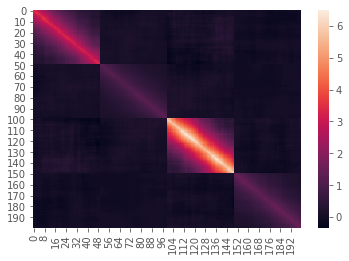

true Sigma
Best MSE we can have (in our dream):  tensor(0.0114)


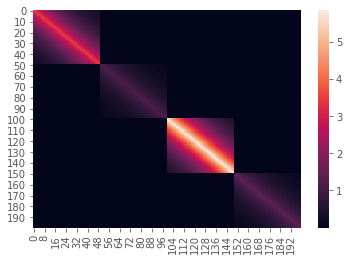

In [11]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z_sampled, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z_sampled.shape[0]*((Z_sampled-mu_MLE).T)@(Z_sampled-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE.to(torch.device('cpu')))
plt.show()
print('true Sigma')
sns.heatmap(true_Sigma.to(torch.device('cpu')))
best_MSE_Sigma = torch.mean((Sigma_MLE.to(device)-true_Sigma)**2)
print('Best MSE we can have (in our dream): ', best_MSE_Sigma)

## Generate some Data according to the true parameters

In [12]:
torch.manual_seed(2)

noise = torch.randn(p) 
Sigma_init =  torch.diag(noise**2)+ 1e-1
#Sigma_init = true_Sigma
C_init = torch.cholesky(Sigma_init)
beta_init = torch.rand((d, p))
#beta_init = true_beta
M_init = torch.randn((n,p))/100# some random values to initialize we divide to avoid nan values 
S_init = torch.randn((n,p))/8 # some random values to initializ. we divise to avoid nan values 

## best model : closed form for $\beta$ and $\Sigma$

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.89781
 MSE with beta :  1.37974
ELBO :  -28470418.05542
Delta :  -28470417.055417903
---------------------------------Maximum number of iterations reached :  1 last delta =  -28470417.055417903
 MSE with Sigma :  0.89781
 MSE with beta :  1.37974
both closed


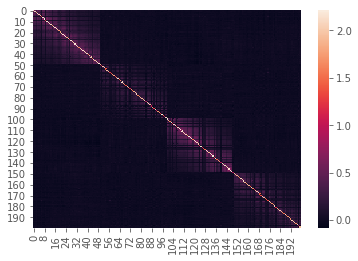

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.80978
 MSE with beta :  0.71249
ELBO :  35588276.7737
Delta :  64058694.82911354
---------------------------------Maximum number of iterations reached :  1 last delta =  64058694.82911354
 MSE with Sigma :  0.80978
 MSE with beta :  0.71249
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.43772
 MSE with beta :  0.5147
ELBO :  55144485.51858
Delta :  19556208.74488482
---------------------------------Maximum number of iterations reached :  1 last delta =  19556208.74488482
 MSE with Sigma :  0.43772
 MSE with beta :  0.5147
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.18077
 MSE with beta :  0.38655
ELBO :  78827260.91778
Delta :  23682775.399197318
---------------------------------Maximum number of iterations reached :  1 last delta =  23682775.399197318
 MSE with Sigma :  0.18077
 MSE with beta :  0.38655
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.15624
 MSE with beta : 

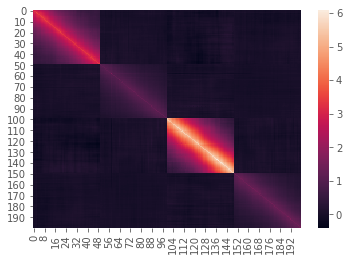

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00549
 MSE with beta :  0.00698
ELBO :  124243597.41589
Delta :  12.871022805571556
---------------------------------Maximum number of iterations reached :  1 last delta =  12.871022805571556
 MSE with Sigma :  0.00549
 MSE with beta :  0.00698
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00552
 MSE with beta :  0.00693
ELBO :  124243609.00578
Delta :  11.589882224798203
---------------------------------Maximum number of iterations reached :  1 last delta =  11.589882224798203
 MSE with Sigma :  0.00552
 MSE with beta :  0.00693
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00555
 MSE with beta :  0.00689
ELBO :  124243619.4075
Delta :  10.401720821857452
---------------------------------Maximum number of iterations reached :  1 last delta =  10.401720821857452
 MSE with Sigma :  0.00555
 MSE with beta :  0.00689
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00558
 MSE wit

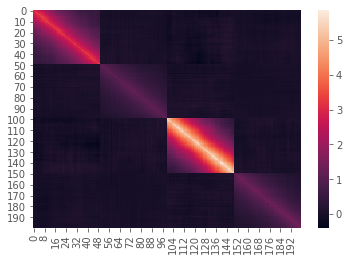

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00663
 MSE with beta :  0.00631
ELBO :  124243723.47602
Delta :  0.20511025190353394
---------------------------------Maximum number of iterations reached :  1 last delta =  0.20511025190353394
 MSE with Sigma :  0.00663
 MSE with beta :  0.00631
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00665
 MSE with beta :  0.00631
ELBO :  124243723.6683
Delta :  0.19227570295333862
---------------------------------Maximum number of iterations reached :  1 last delta =  0.19227570295333862
 MSE with Sigma :  0.00665
 MSE with beta :  0.00631
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00666
 MSE with beta :  0.0063
ELBO :  124243723.84661
Delta :  0.17831206321716309
---------------------------------Maximum number of iterations reached :  1 last delta =  0.17831206321716309
 MSE with Sigma :  0.00666
 MSE with beta :  0.0063
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00667
 MSE

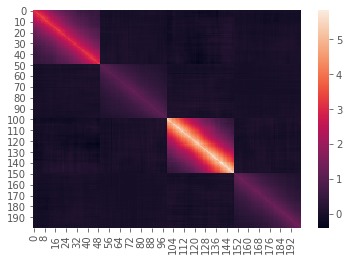

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00693
 MSE with beta :  0.00625
ELBO :  124243726.5456
Delta :  0.011365681886672974
---------------------------------Maximum number of iterations reached :  1 last delta =  0.011365681886672974
 MSE with Sigma :  0.00693
 MSE with beta :  0.00625
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00693
 MSE with beta :  0.00625
ELBO :  124243726.55621
Delta :  0.010609447956085205
---------------------------------Maximum number of iterations reached :  1 last delta =  0.010609447956085205
 MSE with Sigma :  0.00693
 MSE with beta :  0.00625
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00693
 MSE with beta :  0.00625
ELBO :  124243726.56639
Delta :  0.010175451636314392
---------------------------------Maximum number of iterations reached :  1 last delta =  0.010175451636314392
 MSE with Sigma :  0.00693
 MSE with beta :  0.00625
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00

In [15]:
model_VEM = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM.VEM_both_closed(data,Number_VEM_step =200, N_epoch_max = 1,verbose=True, lr = 1)

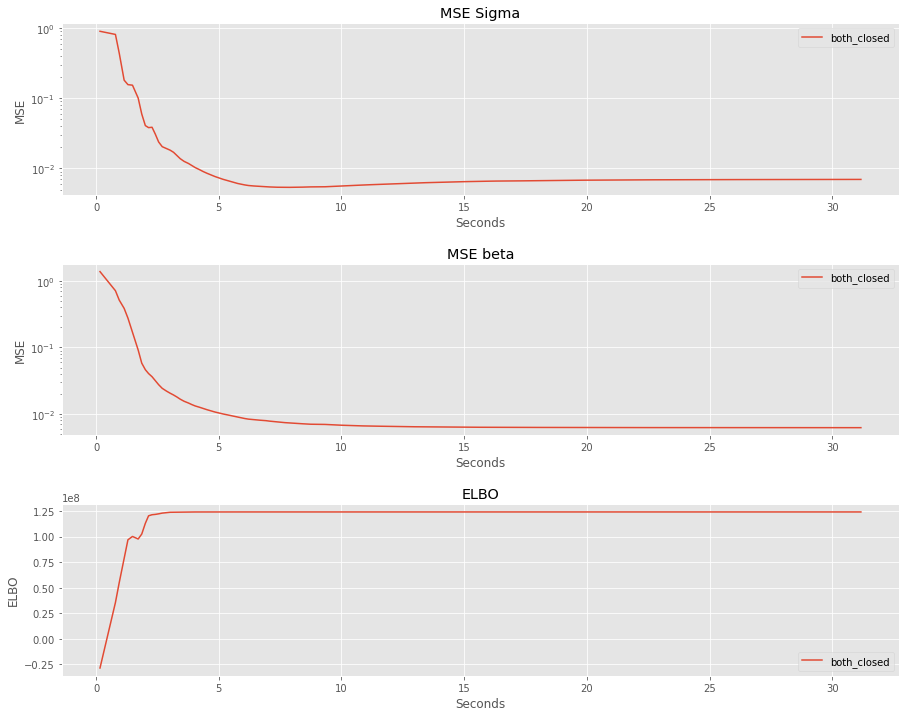

In [16]:
compare_models({'both_closed': model_VEM},None,save = False)

## Comparison of models

### We use threadings to go faster.  Allows to lauch all the models at the same time. 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.90198
 MSE with beta :  1.34943
ELBO :  4208411.97183
Delta :  4208412.971834091
---------------------------------Maximum number of iterations reached :  8 last delta =  1062117.2223260514
 MSE with Sigma :  0.90198
 MSE with beta :  1.34943
both closed


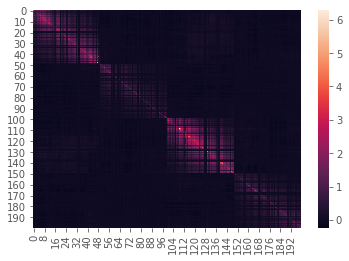

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.55711
 MSE with beta :  0.39032
ELBO :  29239705.19882
Delta :  4657511.290156893
---------------------------------Maximum number of iterations reached :  8 last delta =  100271.18270716071
 MSE with Sigma :  0.55711
 MSE with beta :  0.39032
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.27913
 MSE with beta :  0.24365
ELBO :  32780007.86275
Delta :  129655.49216857553
---------------------------------Maximum number of iterations reached :  8 last delta =  12141.952171113342
 MSE with Sigma :  0.27913
 MSE with beta :  0.24365
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.18305
 MSE with beta :  0.17997
ELBO :  33070803.30271
Delta :  18336.111075609922
---------------------------------Maximum number of iterations reached :  8 last delta =  853.4169366136193
 MSE with Sigma :  0.18305
 MSE with beta :  0.17997
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.13703
 MSE with be

In [44]:
#dict_models_adadelta = launch_models(torch.optim.Adadelta)
dict_models_Rprop = launch_models(torch.optim.Rprop,N_iter = 20, lr = 0.003)

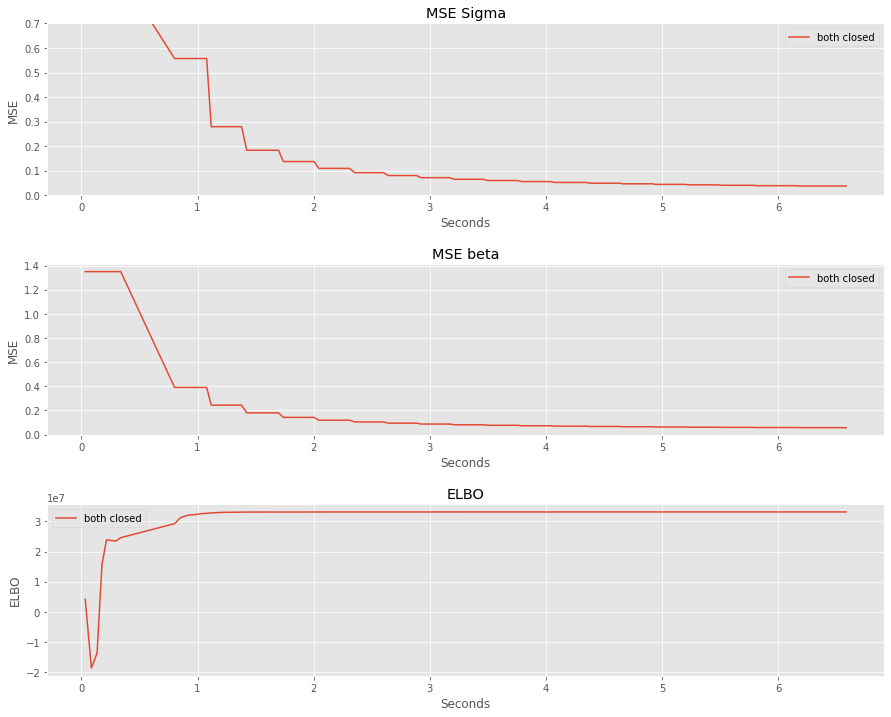

In [45]:
compare_models(dict_models_Rprop,'')

# Comparison of optimizer 

In [17]:
dict_optimizers = {'Adadelta': torch.optim.Adadelta, 
                   'Adam': torch.optim.Adam, 
                   'Adagrad' : torch.optim.Adagrad,
                   'Adamax' : torch.optim.Adamax,
                  'Rprop' : torch.optim.Rprop, 
                   'RMSprop' : torch.optim.RMSprop}

In [53]:
dict_model_optim = launch_optimizers(dict_optimizers,100,0.003)

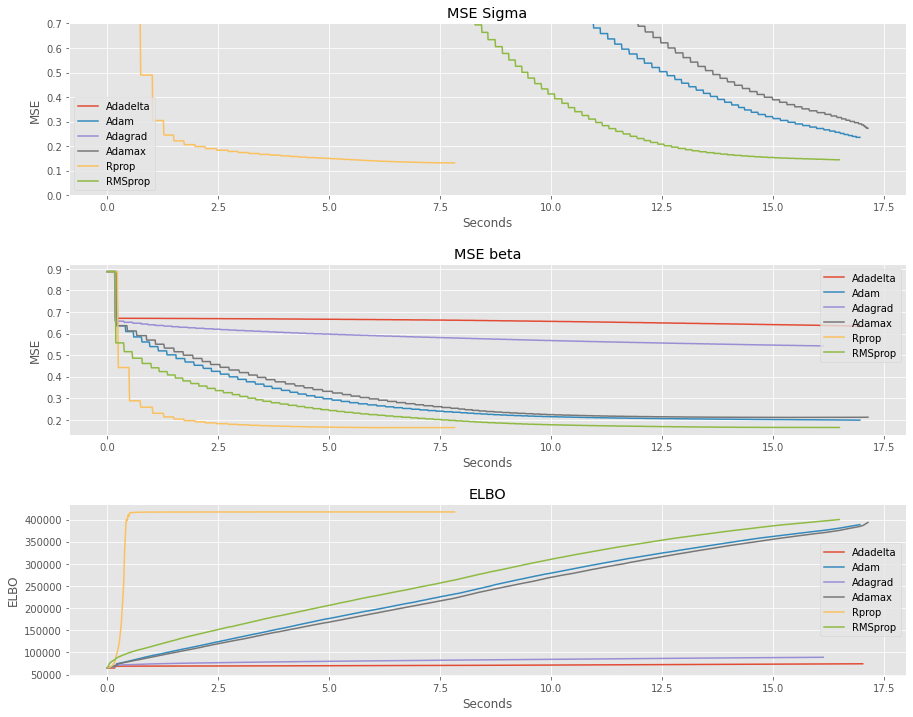

In [54]:
compare_models(dict_model_optim,'')

# Different parametrisatio

# Parametrisation centered in $X\beta$ and variance $CC^{\top}$

### VEM were we use only the closed form for  $\beta$ 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.05939
 MSE with beta :  1.37974
ELBO :  -9757279.79378
Delta :  -9757278.793784192
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  8.65129
 MSE with beta :  1.37974
 i :  0
beta closed


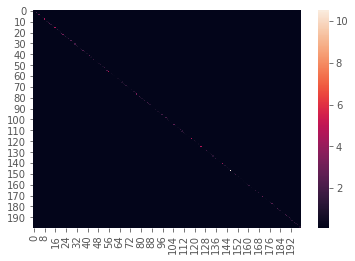

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  8.51551
 MSE with beta :  0.58619
ELBO :  nan
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  6.84123
 MSE with beta :  0.58619
 i :  1
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  6.78334
 MSE with beta :  0.10834
ELBO :  nan
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  6.06422
 MSE with beta :  0.10834
 i :  2
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  6.03806
 MSE with beta :  0.05341
ELBO :  nan
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  5.5779
 MSE with beta :  0.05341
 i :  3
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  5.55625
 MSE with beta :  0.04332
ELBO :  nan
Delta :  nan
---------------------------------Maximum number of itera

In [34]:
model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, requires_tridiag = False)
%time model_VEM_beta.VEM_beta_closed(data,Number_VEM_step =10,verbose=True, lr = 0.05)

### Gradient descent on all the parameters

In [ ]:
model = PLN_full(C_init, beta_init, M_init, S_init)
%time model.full_grad_ascent(data, N_epoch = 20000,verbose=True, lr = 0.003)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01046
 MSE with beta :  1.29332
ELBO :  -309838272.86632
Delta :  -309838271.86632276
iteration number:  200
-------UPDATE-------
 MSE with Sigma :  0.00773
 MSE with beta :  1.27074
ELBO :  32933394.18762
Delta :  62388.91227066517


KeyboardInterrupt: 

# Parametrisation centered in $X\beta$ and variance $\Sigma$

### VEM were we use only the closed form for  $\Sigma$ 

In [ ]:
model_VEM_Sigma = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM_Sigma.VEM_Sigma_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.001)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01056
 MSE with beta :  1.29518
ELBO :  -309838272.86632
Delta :  -309838271.86632276
---------------------------------Maximum number of iterations reached :  20 last delta =  1544552.9421429634
 MSE with Sigma :  0.01056
 MSE with beta :  1.27784
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.04423
 MSE with beta :  1.27703
ELBO :  inf
Delta :  inf
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  1.04423
 MSE with beta :  1.26793
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.9557
 MSE with beta :  1.26759
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.9557
 MSE with beta :  1.26355
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.93862
 MSE with beta :  1.26335
ELBO :  inf
Delta :  nan
---------------------------------Maxi

KeyboardInterrupt: 

### VEM were we use the closed form for  $\beta$ and $\Sigma$. Trully a VEM algorithm. 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.89781
 MSE with beta :  1.37974
ELBO :  -9757279.79378
Delta :  -9757278.793784192
---------------------------------Maximum number of iterations reached :  5 last delta =  10045179.390997814
 MSE with Sigma :  0.89781
 MSE with beta :  1.37974
both closed


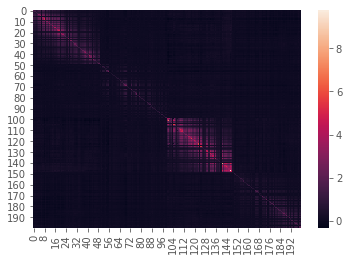

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.49585
 MSE with beta :  0.43947
ELBO :  29865659.49019
Delta :  8426603.97625601
---------------------------------Maximum number of iterations reached :  5 last delta =  3770066.0421898626
 MSE with Sigma :  0.49585
 MSE with beta :  0.43947
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.21272
 MSE with beta :  0.1871
ELBO :  36817544.92285
Delta :  738376.2580789775
---------------------------------Maximum number of iterations reached :  5 last delta =  198456.5481430292
 MSE with Sigma :  0.21272
 MSE with beta :  0.1871
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.12265
 MSE with beta :  0.11829
ELBO :  38139770.18428
Delta :  191589.97761615366
---------------------------------Maximum number of iterations reached :  5 last delta =  85191.83383963257
 MSE with Sigma :  0.12265
 MSE with beta :  0.11829
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08923
 MSE with beta : 

In [25]:
model_VEM = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM.VEM_both_closed(data,Number_VEM_step =20, N_epoch_max = 5,verbose=True, lr = 1)

# Parametrisation centered in $0$ and variance $I$


## Gradient descent with the PCA formula

In [24]:
model_PCA = PLN_full(C_init, beta_init, M_init, S_init)
%time model_PCA.full_grad_ascent_PCA(data, N_epoch = 200,verbose=True, lr = 0.05)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.88284
 MSE with beta :  1.3559
ELBO :  11513260.21212
Delta :  11513261.212117976
---------------------------------Maximum number of iterations reached :  200 last delta =  308.38625126332045
 MSE with Sigma :  0.24012
 MSE with beta :  0.49127
CPU times: user 34.6 s, sys: 120 ms, total: 34.7 s
Wall time: 8.79 s


# Parametrisation centered in 0 and variance Sigma

## VEM of the first notebook  

In [30]:
model_first_VEM = PLN_full(C_init, beta_init, M_init, S_init)
%time model_first_VEM.first_VEM(data,Number_VEM_step =50, N_epoch_max = 20,verbose=True, lr = 1)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.89781
 MSE with beta :  1.85297
ELBO :  11066687.61166
Delta :  11066688.611656656
---------------------------------Maximum number of iterations reached :  20 last delta =  54411.8129151538
 MSE with Sigma :  0.89781
 MSE with beta :  0.89757
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.6263
 MSE with beta :  0.87919
ELBO :  37748340.10548
Delta :  450245.2865931615
---------------------------------Maximum number of iterations reached :  20 last delta =  11243.11646732688
 MSE with Sigma :  0.6263
 MSE with beta :  0.6958
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.39395
 MSE with beta :  0.69159
ELBO :  38426349.99034
Delta :  73461.21364431083
---------------------------------Maximum number of iterations reached :  20 last delta =  1131.840689651668
 MSE with Sigma :  0.39395
 MSE with beta :  0.64952
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.42944
 MSE with beta :

Here we have a PLN model described as the following : 

- Consider $n$ sites $(i=1 \ldots n)$

- Measure $x_{i}=\left(x_{i h}\right)_{1 \leq h \leq d}$ :
$x_{i h}=$ given environmental descriptor (covariate) for site $i$
(altitude, temperature, latitude, ...)

- Consider $p$ species $(j=1 \ldots p)$ Measure $Y=\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ :

- Measure $Y = Y_{i j}=$ number of observed individuals from species $j$ in site $i$ (abundance). 

- Associate a random vector $Z_{i}$ with each site Assume that the unknown $\left(Z_{i}\right)_{1 \leq i \leq n}$ are independant such that:
$$
Z_{i} \sim \mathcal{N}_{p}(x_i \beta, \Sigma) \quad \Sigma = CC^{\top}
$$

and $C$ is a lower triangular matrix. 
- Assume that the observed abundances $\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ are independent conditionally on the $Z=\left(Z_{i}\right)_{i}$


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
$$

Where $O = (o_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ are known offsets. 

The unknown parameter is $\theta = (C,\beta)$.

$Z$ being a latent variable, we want to use the EM algorithm to derive the maximum likelihood estimator. However, it requires to compute 

$$
\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y\right)\right]=\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y_{i}\right)\right] \propto \int_{\mathbb{R}^{p}} p_{\theta}\left(Z_{i}\right) \prod_{j} p_{\theta}\left(Y_{i j} \mid Z_{i j}\right) \mathrm{d} Z_{i}
$$ which is intractable in practice. 

We thus choose the variationnal approximation. We set

$$ 
q^{\star} = \underset{q \in \mathcal{Q_{gauss}}}{\operatorname{argmax}} J_{\theta,q}(Y) 
$$
<br>
$$
\begin{align} J_{\theta, q}(Y)& =\log p_{\theta}(Y)-K L\left[q(Z) \| p_{\theta}(Z \mid Y)\right]                                    \\ 
                              & = \mathbb{E}_{q}\left[\log p_{\theta}(Y, Z)\right] \underbrace{-\mathbb{E}_{q}[\log q(Z)]}_{\text {entropy } \mathcal{H}(q)}    \end{align}
$$

where 

$$
\mathcal{Q}_{\text {Gauss }}=\{
q=\left(q_{1}, \ldots q_{n}\right), q_{i} \sim \mathcal{N}\left(M_{i}, \operatorname{diag} (S_{i}\odot S_i ), M_i \in \mathbb{S} ^p, S_i \in \mathbb{R} ^p\right)\}
$$


The Variational EM (VEM) consists in alternate between two steps : 
- VE step: update $q$
$$
q^{h+1}=\underset{q \in \mathcal{Q_{gauss}}}{\arg \max } J_{\theta^{h}, q}(Y)=\underset{q \in \mathcal{Q_{gauss}}}{\arg \min } K L\left[q(Z) \| p_{\theta^{h}}(Z \mid Y)\right]
$$
- M step: update $\theta$
$$
\theta^{h+1}=\underset{\theta}{\arg \max } J_{\theta, q^{h+1}}(Y)=\underset{\theta}{\arg \max } \mathbb{E}_{q^{h+1}}\left[\log p_{\theta}(Y, Z)\right]
$$

Let's compute the ELBO $J_{\theta, q}(Y)$


$$
J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_{i}\right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i j}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+Z_{i j}\right)-\exp \left(o_{i j}+Z_{i j}\right)\right] + cst
\end{align}
$$

We need to compute some moments of $Z$ under $q$. 

$$
\mathbb{E}_{q}\left[Z_{i j}\right]=M_{i j} \quad \quad E_{q}\left[\operatorname{exp}\left(Z_{i j}\right)\right]=\frac{1}{2} \operatorname{exp}\left(M_{i j}+\frac{(S_{ij})^2}{2}\right)
$$

So that 

$$
\begin{aligned}
(1) &=\sum_{i, j} Y_{i j}\left(o_{i j}+M_{i j}\right)-\frac{1}{2} \exp \left(o_{i j}+M_{i j}+\frac{(S_{i_{jj}})^2}{2}\right) + cst \\
&=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S \odot S}{2}\right)\right)\mathbb{1}_p + cst 
\end{aligned}
$$



Where we have denoted $M = (M_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ and $ S = (S_{ij})_{1\leq i\leq n, 1\leq j\leq p}$. The exponential is applied pointwise on the last equation. 

$$
\begin{aligned}
(3)=H(q) &=\sum_{i} H\left(q_{i}\right) \\
&=\sum_{i} \log \left(\sqrt{(2 \pi e)^{p}\left|S_{i}\right|}\right) \\
&=\frac 12\sum_{i} \log (S_{i} \odot S_i)^2 +cst \\
&= \frac 12 \sum_{i j} \log S_{i j}^2+cst \\
& = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst\\
\end{aligned}
$$

Where the log is applied pointwise at the last equation. 

$$
\begin{aligned}
(2)=\mathbb{E}_{q}\left[\log p_{\theta}(Z)\right] &=\sum_{1} E_{q}\left[\log p_{\theta}\left(Z_{i}\right)\right] \\
&=-\frac{n}{2} \log |\Sigma|+\sum_{i} \mathbb{E}_{q}\left[-\frac{1}{2}\left(Z_{i}-X_{i} \beta\right)^{\top} \Sigma^{-1}\left(Z_{i} - X_{i} \beta\right)\right] +cst
\end{aligned}
$$

$
\text { Let } V \sim \mathcal{N} \left(\mu, \Lambda), \mu \in \mathbb{R}^{p}, \Lambda \in \mathcal S _p ^{++}\right.  \\
\text { Let's compute } \; \mathbb{E}\left[V^{\top} \Sigma^{-1} V\right]
$

We denote $\Sigma ^{-1 / 2}$ the square root Matrix of $\Sigma^{-1}$. It exists since $\Sigma ^{-1} \in \mathcal{S}_p^{++}$. 

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\left[V^{\top}\Sigma ^{-1 / 2} \Sigma^{-1 / 2} V\right]\\
&=\mathbb{E}\left[\left(\Sigma^{-1 / 2} V\right)^{\top}\left(\Sigma^{-1 / 2} V\right)\right] \\
&=\mathbb{E} \|\Sigma^{-1 / 2} V \|_{2}^{2}
\end{aligned}
$$

$
\text {Let } \tilde{V}=\Sigma^{-1 / 2} V, \quad \tilde{V} \sim \mathcal{N}\left(\Sigma^{-1 / 2} \mu,  \Sigma^{-1 / 2} \Lambda \Sigma^{-\frac{1}{2}}\right)
$

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\|\widetilde{V}\|_{2}^{2} \\
&=\sum \mathbb E \widetilde{V}_{j}^{2} \\
&=\sum \operatorname{var}\left(\widetilde{V}_{j}\right)^{2}+\mathbb{E}\left[\widetilde{V}_{j}\right]^{2}\\
&=\sum_{j}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)_{j j}+\left(\Sigma^{-1 / 2} \mu\right)^{2}_j\\
&= \operatorname{tr}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1 / 2}\right)^{\top} \mu\right)^{2}\\
&=\operatorname{tr}\left(\Sigma^{-1} \Lambda\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1/2}\right)^{\top} \mu\right)^2
\end{aligned}
$$

Since under $q$, $Z_{i}-X_{i} \beta \sim \mathcal N (M_i - X_i \beta, S_i \odot S_i ) $
$$
\begin{equation}
\begin{aligned}
(2) &=- \frac 12 \sum_{i} \operatorname{tr}\left(\Sigma^{-1} (S_{i} \odot S_i) \right) - \frac 12 \sum_{i, j}\left(\left(\Sigma_{j,.}^{-1 / 2} \right) ^{\top}\left(M_{i}-X_{i} \beta\right)\right)^2  - \frac n2 \log |\Sigma|+ cst  \\
&= - \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i}\odot S_i \right)\right) - \frac 12 \sum_{i, j}\left(\Sigma^{-1 / 2}(M-X \beta)\right)_{j, i}^{\top}\left(\Sigma
^{-1 / 2}(M-X \beta)\right)_{i, j}  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i} \odot S_i  \right)\right)- \frac 12 \operatorname{tr}\left(\Sigma^{-1 / 2}(M-X \beta)^{\top}(M-X \beta) \Sigma^{-1 / 2}\right)  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right)  - \frac n2 \log |\Sigma|+ cst 
\end{aligned}
\end{equation}
$$
We then have : 

PARAMETRISATION CENTERED IN $X\beta$ and variance $\Sigma$


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$



If we use $C$ instead of $\Sigma$ : 


PARAMETRISATION CENTERED IN $X\beta$ and variance $CC^{\top}$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

We consider the same setting but another parametrization of the model : 

$$
\begin{array}{l}
Z_{i} \sim \mathcal N_{p}\left(0, I_{p}\right) \\
Y_{i j} \mid Z_{i} \sim \mathcal P \left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right)
\end{array}
$$
Writing in Matrix form : 

$$
Y \mid Z \sim \mathcal P\left(\exp \left(O+X \beta+ ZC\right)\right)
$$

This parametrization asks less things to the Variational part. 

Let's compute the ELBO $\tilde J_{\theta, q}(Y)$ of this new parametrisation. 


$$
\tilde J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_i \right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+x_{i}^{\top} \beta_{j}+ C_{j}^{\top} Z_i\right)-\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right] + cst
\end{align}
$$

Let $1\leq i \leq n, 1 \leq j \leq p$. Let's compute $\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right]$


$$
\begin{aligned}
\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right] &=\mathbb{E}_{q}\left[\exp \left(\sum_{k=1}^{p} C_{j k}Z_{ik}\right)\right] \\
&=\mathbb{E}_{q}\left[\prod_{k=1}^{p} \exp \left(C_{j k} Z_{i k}\right)\right] \\
&=\prod_{k=1}^p\mathbb{E}_{q} \left[\exp \left(C_{j k} Z_{i k}\right)\right] \\ 
&=\prod_{k=1}^{p} exp \left(M_{i_{k}} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&= \exp \left(\sum_{k=1}^{p} M_{i k} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&=\exp \left(M_{i}^{\top} C_{j}+\frac{\left(S_{i}^{2}\right)^{T} C_{j}^2}{2}\right)
\end{aligned}
$$

Ainsi, 

$$
(1)=1_{n}^{\top}\left(Y \odot (O+X \beta+MC) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{  (S \odot S)(C\odot C) }{2}\right)\right)1_{p}
$$

For $(2)$, we take $X\beta = 0, \Sigma = I_p$ in $(2)$ from the previous parametrisation to get : 
$$
(2) = - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right)  - \frac {n}2 \log 1 + cst 
$$

For $(3)$, we have a similar argument as in $(3)$ from previous parametrisation to get : 

$$(3) = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst$$

We then get : 

PARAMETRISATION CENTERED IN 0 AND UNIT VARIANCE 

$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+C M) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{(C\odot C)   (S \odot S)}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$

We can have a last parametrization that is : 

$$
Z_{i} \sim \mathcal{N}_{p}(0, \Sigma)
$$

and 


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)\right)
$$

This model is equivalent to the other ones but the variational step is different. 

PARAMETRISATION CENTERED IN 0 AND VARIANCE $\Sigma$

$$
\boxed{
\begin{aligned}
J_{\theta, q}(y) &=-\frac{n}{2} \log |\Sigma|-\frac{1}{2} \sum_{i} m_{i}^{\top} \Sigma^{-1} m_{i}+tr\left(\Sigma^{-1} S_{i}\right) \\
&+\sum_{i, j}-\exp \left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}+\left[S_{i}\right]_{j j}^{2} / 2\right)+Y_{i j}\left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}\right) \\
&+\frac{1}{2} \sum_{i} \log \left|(S\odot S)_{i}\right|+c s t .
\end{aligned}}
$$
    

In [ ]:
def f(x) : 
    return x**2

x = torch.tensor([8.])
x.requires_grad_(True)
test_optim = torch.optim.SGD([x], lr = 2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(test_optim, factor = 0.5, patience = 1)

for i in range(100): 
    
    print('normalement : ',x-2*test_optim.param_groups[0]['lr']*x)
    loss = f(x)
    loss.backward()
    test_optim.step()
    scheduler.step(loss.item())
    test_optim.zero_grad()
    print('lr : ', test_optim.param_groups[0]['lr'])
    print('x : ', x )

normalement :  tensor([-24.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([-24.], requires_grad=True)
normalement :  tensor([72.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([72.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([216.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], 